In [1]:
# -*- coding: utf-8 -*-
from __future__ import division
import argparse
import bz2
from datetime import datetime
import os
import pickle
from logger import Logger

import atari_py
import numpy as np
import torch
from tqdm import trange

from agent import Agent
from env import Env
from sunrise_memory import ReplayMemory
from test import ensemble_test
from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt

In [3]:
class DataObject:
    def __init__(self):
        self.seed = 123
        self.game = 'boxing'
        self.T_max = 100000
        self.num_ensemble = 5
        self.beta_mean = 0.5
        self.memory_capacity = 500000
        self.id = 'vae_sunrise'
        self.temperature = 10
        self.learn_start = 1600
        self.target_update = 2000
        self.replay_frequency = 1
        self.multi_step = 20
        self.discount = 0.99
        self.architecture = 'data-efficient'
        self.max_episode_length = int(108e3)
        self.history_length = 4
        self.atoms = 51
        self.V_min = -10
        self.V_max = 10
        self.batch_size = 32
        self.model = None
        self.hidden_size = 256
        self.noisy_std = 0.1
        self.evaluation_size = 12000
        self.learning_rate = 0.0001
        self.adam_eps = 1.5e-4
        self.priority_weight = 0.4
        self.priority_exponent = 0.5
        
        
        if torch.cuda.is_available():
            self.device = torch.device('cuda')
            torch.cuda.manual_seed(np.random.randint(1, 10000))
            torch.backends.cudnn.enabled = True
            torch.set_default_tensor_type('torch.FloatTensor')

In [4]:
args = DataObject()

In [5]:
args.device

device(type='cuda')

In [6]:
# Environment
env = Env(args)
env.train()
action_space = env.action_space()

# Agent
dqn_list = []
for _ in range(args.num_ensemble):
    dqn = Agent(args, env)
    dqn_list.append(dqn)

# If a model is provided, and evaluate is fale, presumably we want to resume, so try to load memory
if args.model is not None and not args.evaluate:
    if not args.memory:
        raise ValueError('Cannot resume training without memory save path. Aborting...')
    elif not os.path.exists(args.memory):
        raise ValueError('Could not find memory file at {path}. Aborting...'.format(path=args.memory))
    mem = load_memory(args.memory, args.disable_bzip_memory)

else:
    mem = ReplayMemory(args, args.memory_capacity, args.beta_mean, args.num_ensemble)

priority_weight_increase = (1 - args.priority_weight) / (args.T_max - args.learn_start)

# Construct validation memory
val_mem = ReplayMemory(args, args.evaluation_size, args.beta_mean, args.num_ensemble)
T, done = 0, True
for i in tqdm(range(args.evaluation_size)):
    if done:
        state, done = env.reset(), False
    next_state, _, done = env.step(np.random.randint(0, action_space))
    val_mem.append(state, 0, 0, done)
    state = next_state
    T += 1

100%|██████████| 12000/12000 [00:22<00:00, 527.05it/s]


In [81]:
# Copyright (c) Facebook, Inc. and its affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.

import torch
import torch.nn as nn


class PixelDecoder(nn.Module):
    def __init__(self, obs_shape, feature_dim, num_layers=2, num_filters=32):
        super().__init__()

        self.num_layers = num_layers
        self.num_filters = num_filters
        self.init_height = 4
        self.init_width = 4
        num_out_channels = 1  # stacked_frames
        kernel = 3

        self.fc = nn.Linear(
            feature_dim, num_filters * self.init_height * self.init_width
        )

        self.deconvs = nn.ModuleList()

        pads = [0, 1, 0]
        for i in range(self.num_layers - 1):
            output_padding = pads[i]
            self.deconvs.append(
                nn.ConvTranspose2d(num_filters, num_filters, kernel, stride=2, output_padding=output_padding)
            )
        self.deconvs.append(
            nn.ConvTranspose2d(
                num_filters, num_out_channels, kernel, stride=2, output_padding=1
            )
        )

        self.outputs = dict()

    def forward(self, h):
        h = torch.relu(self.fc(h))
        self.outputs['fc'] = h

        deconv = h.view(-1, self.num_filters, self.init_height, self.init_width)
        self.outputs['deconv1'] = deconv

        for i in range(0, self.num_layers - 1):
            deconv = torch.relu(self.deconvs[i](deconv))
            self.outputs['deconv%s' % (i + 1)] = deconv

        obs = self.deconvs[-1](deconv)
        self.outputs['obs'] = obs

        return obs

    def log(self, L, step, log_freq):
        if step % log_freq != 0:
            return

        for k, v in self.outputs.items():
            L.log_histogram('train_decoder/%s_hist' % k, v, step)
            if len(v.shape) > 2:
                L.log_image('train_decoder/%s_i' % k, v[0], step)

        for i in range(self.num_layers):
            L.log_param(
                'train_decoder/deconv%s' % (i + 1), self.deconvs[i], step
            )
        L.log_param('train_decoder/fc', self.fc, step)


_AVAILABLE_DECODERS = {'pixel': PixelDecoder}


def make_decoder(
    decoder_type, obs_shape, feature_dim, num_layers, num_filters
):
    assert decoder_type in _AVAILABLE_DECODERS
    return _AVAILABLE_DECODERS[decoder_type](
        obs_shape, feature_dim, num_layers, num_filters
    )

# Copyright (c) Facebook, Inc. and its affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.

import torch
import torch.nn as nn


def tie_weights(src, trg):
    assert type(src) == type(trg)
    trg.weight = src.weight
    trg.bias = src.bias


class PixelEncoder(nn.Module):
    """Convolutional encoder of pixels observations."""
    def __init__(self, obs_shape, feature_dim, num_layers=2, num_filters=32, stride=None):
        super().__init__()

        assert len(obs_shape) == 3

        self.feature_dim = feature_dim
        self.num_layers = num_layers

        self.convs = nn.ModuleList(
            [nn.Conv2d(obs_shape[0], num_filters, 3, stride=2)]
        )
        for i in range(num_layers - 1):
            self.convs.append(nn.Conv2d(num_filters, num_filters, 3, stride=1))

        out_dim = {2: 39, 4: 35, 6: 31}[num_layers]
        self.fc = nn.Linear(num_filters * out_dim * out_dim, self.feature_dim)
        self.ln = nn.LayerNorm(self.feature_dim)

        self.outputs = dict()

    def reparameterize(self, mu, logstd):
        std = torch.exp(logstd)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward_conv(self, obs):
        self.outputs['obs'] = obs

        conv = torch.relu(self.convs[0](obs))
        self.outputs['conv1'] = conv

        for i in range(1, self.num_layers):
            conv = torch.relu(self.convs[i](conv))
            self.outputs['conv%s' % (i + 1)] = conv

        h = conv.view(conv.size(0), -1)
        return h

    def forward(self, obs, detach=False):
        h = self.forward_conv(obs)

        if detach:
            h = h.detach()

        h_fc = self.fc(h)
        self.outputs['fc'] = h_fc

        out = self.ln(h_fc)
        self.outputs['ln'] = out

        return out

    def copy_conv_weights_from(self, source):
        """Tie convolutional layers"""
        # only tie conv layers
        for i in range(self.num_layers):
            tie_weights(src=source.convs[i], trg=self.convs[i])

    def log(self, L, step, log_freq):
        if step % log_freq != 0:
            return

        for k, v in self.outputs.items():
            L.log_histogram('train_encoder/%s_hist' % k, v, step)
            if len(v.shape) > 2:
                L.log_image('train_encoder/%s_img' % k, v[0], step)

        for i in range(self.num_layers):
            L.log_param('train_encoder/conv%s' % (i + 1), self.convs[i], step)
        L.log_param('train_encoder/fc', self.fc, step)
        L.log_param('train_encoder/ln', self.ln, step)


def make_encoder(
    encoder_type, obs_shape, feature_dim, num_layers, num_filters, stride
):
    assert encoder_type in _AVAILABLE_ENCODERS
    return _AVAILABLE_ENCODERS[encoder_type](
        obs_shape, feature_dim, num_layers, num_filters, stride
    )

class VAE(nn.Module):
    def __init__(self, obs_shape):
        super().__init__()
        self.encoder = make_encoder(
            encoder_type='pixel', 
            obs_shape=obs_shape, 
            feature_dim=100, 
            num_layers=4, 
            num_filters=32,
            stride=1
        ).to(device)
        
        self.decoder = make_decoder(
                'pixel', obs_shape, 50, 4, 32).to(device)

    def train(self, obs):
        h = self.encoder(obs)
        mu, log_var = h[:, :50], h[:, 50:]
        eps = torch.randn_like(mu)
        reparam = mu + torch.exp(log_var / 2) * eps
        rec_obs = torch.sigmoid(self.decoder(reparam))
        BCE = F.binary_cross_entropy(rec_obs, obs , reduction='sum')
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = BCE + KLD
        return loss
    
import torch.nn.functional as F

In [82]:
device = torch.device('cuda')

In [83]:
vae = VAE((1,57,50))

In [94]:
vae.encoder(states[:,0,14:-13,17:-17].reshape(32,1,57,50))

RuntimeError: size mismatch, m1: [32 x 12672], m2: [39200 x 100] at /opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/THC/generic/THCTensorMathBlas.cu:290

In [85]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-2)

# training loop
for i in tqdm(range(6000)):
    total_loss = []
    idxs, states, actions, returns, next_states, nonterminals, weights, masks = val_mem.sample(32)
    optimizer.zero_grad()
#     loss = vae.train(states[:,0,:,:].reshape(32,1,84,84).to(device).float()) 
    loss = vae.train(states[:,0,14:-13,17:-17].reshape(32,1,57,50).to(device).float()) 
    loss.backward()
    optimizer.step()
    total_loss.append(loss.item())

    print(np.mean(total_loss), i)

  0%|          | 0/6000 [00:00<?, ?it/s]


RuntimeError: size mismatch, m1: [32 x 12672], m2: [39200 x 100] at /opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/THC/generic/THCTensorMathBlas.cu:290

In [ ]:
states[::4,:,14:-13,17:-17].shape

In [30]:
latent_var = vae.encoder.forward(states[:,0,:,:].reshape(32,1,84,84))

In [31]:
vae.encoder.convs

ModuleList(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
  (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
)

In [32]:
mu, log_var = latent_var[:, :50], latent_var[:, 50:]
eps = torch.randn_like(mu)
reparam = mu + torch.exp(log_var / 2) * eps
rec_obs = torch.sigmoid(vae.decoder(reparam))

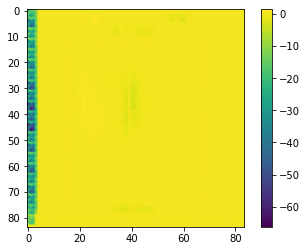

In [33]:
plt.imshow(vae.decoder(reparam)[2,0].cpu().detach().numpy())
plt.colorbar()

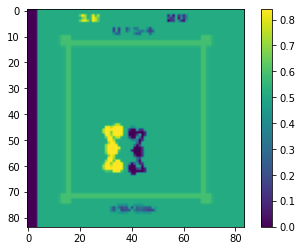

In [36]:
plt.imshow(states[0,0].cpu().detach().numpy())
plt.colorbar()

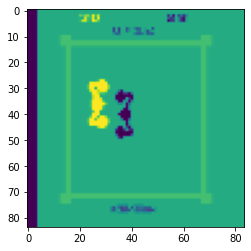

In [35]:
plt.imshow(states[11,0].cpu().detach().numpy())

In [54]:
from sklearn.manifold import TSNE

In [55]:
latent = reparam.cpu().detach().numpy()

In [64]:
embed = TSNE(perplexity=10)

In [65]:
tsne_embedding = embed.fit_transform(latent)

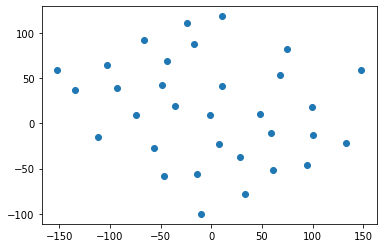

In [66]:
plt.scatter(tsne_embedding[:,0], tsne_embedding[:,1])